## <CENTER> Fitting functions to distributions in ROOT: tips and examples

In [1]:
# import several types of objects we'll need (the ones starting with k represent predefined colors)
from ROOT import TH1F, TCanvas, TF1, TGraphErrors, TLegend, kRed, kBlue, kGreen, kBlack

Welcome to JupyROOT 6.14/00


###  2.1 Uncertainties
________________________

In [2]:
# create a histogram
histo = TH1F("histo", "; x; Number of events", 20, -3., 3.)
# set the number of entries to run over
nEntries = 500
# fill the histogram with randomised values from a function
# for example the pre-defined function "expo" is an exponential with two parameters: 
# e^([parameter0] + [parameter1]*x). Other examples are "gaus", "landau", ...
fname = "expo" 
histo.FillRandom(fname, nEntries) # fill nEntries times

In [3]:
# activate the interactive visualization
%jsroot on

In [4]:
# create a canvas to draw the histogram on
canvas = TCanvas("canvas", "", 800, 600)

In [5]:
# draw the histogram
histo.Draw("e1")
canvas.Draw()

#### Note that each point is drawn with a vertical bar representing the uncertainty of the value. Find out what this uncertainty is equal to. 

In [7]:
%run hints/hint2.py

Button(description='Give hint', style=ButtonStyle())

Hover with the mouse over a data point to see its value and corresponding uncertainty.


____________________________________________________________________________________

### 2.2 Make a fit
Now let's fit a function to the data in the histogram. The syntax is `TH1F::Fit(fcn, "fit_opt", "draw_opt", xlow, xup)` where
* `fcn` is either a string with the name of a function or a pointer to the function object itself. By function we mean a TF object (TF1 for a 1-dimensional function)
* `"fit_opt"` are fit options, `"draw_opt"` are draw options, you can set e.g. `fit_opt = "V"` for more detailed fit diagnostics and `draw_opt="E"` to draw the histogram with errors. Several options can be given simultaneously by combining several letters into a string.
* `x_low` and `x_up` define the range to be used for the fit. 

See further documentation at https://root.cern.ch/doc/master/classTH1.html#a7e7d34c91d5ebab4fc9bba3ca47dabdd. You can read e.g. about the different fit options to control the fit (more on this soon).

Here we'll try to fit the same function we used to fill the histogram (should by definition work well).
By calling `histo.Fit()` the fit is performed and the resulting curve is drawn in the canvas on top of the histogram.
By default a weighted least-squares fit is used, also denoted $\chi^2$-fit.
___________________________________________

In [8]:
fitresult = histo.Fit(fname, "S") # fit option "S" makes sure the fit result is returned
print("\n****** Fit results: ")
canvas.Draw() 


****** Fit results: 
 FCN=11.1487 FROM MIGRAD    STATUS=CONVERGED      50 CALLS          51 TOTAL
                     EDM=6.99001e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.01321e+00   1.10331e-01   7.69597e-05  -3.04534e-04
   2  Slope        9.93862e-01   4.97127e-02   3.46776e-05  -1.31571e-03


Above the figure the parameters resulting from the fit are printed. Look for example at the `STATUS` which shows if the fit converged (found the minimum) or not. The best-fit values of the parameters and their corresponding uncertainties are printed. By passing fit option `"V"` more verbose output will be given.

Print out the relative uncertainty on the `Slope` parameter below:

In [11]:
%run hints/hint4.py

Button(description='Tip get fit results', style=ButtonStyle())

'fitresult' is an object of class 'TFitResult'. The parameter values are obtained with function 'Parameter(i)'. Look at the documentation https://root.cern.ch/doc/master/classROOT_1_1Fit_1_1FitResult.html to find the function for retrieving parameter errors.


In [12]:
# print("Relative uncertainty Slope = ...."

#### Now go back and increase the number of entries in the histogram to double and rerun the fit. What happens to the uncertainty? What if you increase by a factor of four? Explain.

___________________________________________________________________________

### 2.3   Goodness-of-fit
How can we quantify how good a fit is? 
One way is to use the fact that the least-squares sum follows a $\chi^2$ distribution, provided certain conditions are fulfilled.
The number of degress of freedom $N_\rm{DOF}$ is equal to the number of data points (bins) minus the number of parameters to be determined.
With this, the probability to get the observed value for the sum can be evaluated.
More roughly, one can consider the ratio between the sum and the number of degrees of freedom. 
Since each term in the sum should on average contribute around one, the ratio should be close to one for a good fit. 
The ratio is called the "reduced chi-square".
Use the measure with care: the $\chi^2$ assumption only holds if the model is correct, linear in the parameters, and the data points are approximately Gaussian with uncertainties estimated correctly.

Below we investigate this by making a fit to a square wave form.
A short assignment follows.

In [14]:
import math
# create a square wave form
squareWave = TH1F("squareWave", "; x; y", 3, 0.5, 3.5)
squareWave.SetBinContent(1, 5.); squareWave.SetBinError(1, math.sqrt(5.))
squareWave.SetBinContent(2, 15.); squareWave.SetBinError(2, math.sqrt(15.))
squareWave.SetBinContent(3, 5.); squareWave.SetBinError(3, math.sqrt(5.))
squareWave.SetLineColor(kBlack)

# sample from it, dump it to a histogram
sample_squareWave = TH1F("sample_squareWave", "; x; y", 15, 0.5, 3.5)
n = 8000
sample_squareWave.FillRandom(squareWave, n)

# draw the original model and the sampled values
sample_squareWave.Draw("e1")
squareWave.Scale(float(n)/((15.+5.+5.)/3)/sample_squareWave.GetNbinsX()) 
squareWave.Draw("hist same")
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: squareWave (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sample_squareWave (Potential memory leak).


In [16]:
# now let's make a fit using a constant
const = TF1("const", "[0]", 0.5, 3.5, 1) # here "const" is a predefined function with one parameter, y = [0]
const.SetParameter(0, 10.)
fitresult = sample_squareWave.Fit("const", "S", "SAME", 0.5, 3.5)
print("\n*** Chi-square sum = {:.1f}, number of DOF = {}, ratio = {:.1f}".format(fitresult.Chi2(), 
                                                                                 fitresult.Ndf(),
                                                                                 fitresult.Chi2()/fitresult.Ndf()))
canvas.Draw()


*** Chi-square sum = 1886.5, number of DOF = 14, ratio = 134.7
 FCN=1886.47 FROM MIGRAD    STATUS=CONVERGED      12 CALLS          13 TOTAL
                     EDM=4.4788e-15    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.07568e+02   5.21260e+00   1.10576e-01   1.81569e-08


As expected, the fit puts the line somewhere in between the upper and lower part of the pulse.
From the print-out we note that the $\chi^2/N_\rm{DOF}$ is far from one.
The model does not describe the data well.

<b> Now try to fit only a range in which a constant should be a good description of the data.
    Evaluate $\chi^2/N_\rm{DOF}$. Is it closer to one? </b>

____________________________________________________________________________
### 2.4 Configuring the fit
By default, the fit is done by minimizing the sum of weighted least-squares ($\chi^2$). This is based on the assumption that the measured values come from a Gaussian distribution. In our case, they are counts, and come from the Poisson distribution. We know however that the Poisson distribution becomes increasingly Gaussian-like with increasing expectation value. 

You can give the fit option `"L"` to instead make a maximum likelihood fit. In this case, a likelihood function is maximised, where the function is equal to the product of Poisson terms. There is one term for each bin.  

Let's compare the two alternatives using an example. Consider a model equal to a straight line. We generate a number of events from the model and draw the histogram, corresponding to the observation made by an experiment. The goal is to measure the model's slope by performing a fit.
_______________________________________________________________________________

In [17]:
# model
xlow = 3.; xup = 10.
fmodel = TF1("lin", "[0]*x+[1]", xlow, xup)

# set the parameter values
fmodel.SetParameters(1., 1.)

# create a histogram
hist = TH1F("exp", "; x; Number of events", 10, xlow, xup)
n = 30
hist.FillRandom("lin", n) # fill the histogram with n randomly generated numbers from the function

# fit with the default least squares method
fitresult = hist.Fit("lin", "S", "e1") # store the fit results using fit option "S"

# retrieve the resulting parameter values from the fit and their corresponding uncertainties
print(fitresult.Parameter(0))
print(fitresult.ParError(0))

# save the function and draw it again in blue (to prevent it from disappearing when drawing the same function again later)
fresultLeastSquares = hist.GetFunction("lin").Clone("linLeastSquares") # Clone() creates a copy of the function
fresultLeastSquares.SetLineColor(kBlue)
fresultLeastSquares.Draw("SAME")
print("\nSlope least squares = {:.3f}".format(fresultLeastSquares.GetParameter(0)))

# Perform another fit, this time with option "L". The resulting curve is shown in red
hist.Fit("lin", "L", "e1 SAME")
print("Slope likelihood = {:.3f}\n".format(hist.GetFunction("lin").GetParameter(0)))
canvas.Draw()

-0.18738109197956654
0.2250904596129787

Slope least squares = -0.187
Slope likelihood = -0.088

 FCN=5.0155 FROM MIGRAD    STATUS=CONVERGED      30 CALLS          31 TOTAL
                     EDM=8.86375e-23    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -1.87381e-01   2.25090e-01   8.18609e-05  -5.42492e-11
   2  p1           3.71643e+00   1.62298e+00   5.90246e-04  -1.50476e-11
 FCN=2.43391 FROM MIGRAD    STATUS=CONVERGED      43 CALLS          44 TOTAL
                     EDM=2.48372e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -8.78281e-02   3.04679e-01   9.46665e-05  -1.95239e-03
   2  p1           3.57080e+00   2.08115e+00   6.46875e-04  -2.85345e-04
          

#### Note that the two curves to do not overlap. Try what happens if you increase the number of events. Explain.
_______________________________________________________________________________

### 2.5 Define your own functions
______________________________________________________________________

In [18]:
# NB! The interactive feature unfortunately does not work for all functions. 
# We'll turn it off to make sure everything is drawn correctly.
%jsroot off

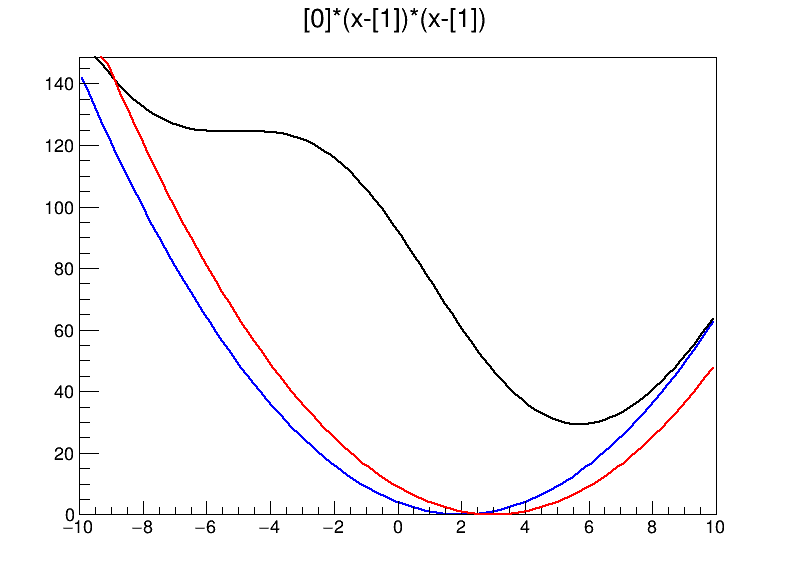

In [20]:
# define your own function, starting with f(x) = a*(x-b)^2

### Alternative 1: write the formula as a string using "TFormula"-syntax
f1 = TF1("f1", "[0]*(x-[1])*(x-[1])", -10., 10.) # [i] represent parameters, the last two arguments are the range for the function

### Alternative 2: write with already existing functions (pre-defined eller user defined)
f2 = TF1("f2", "gaus + f1", -10., 10.)

### Alternative 3: using your own python function
def myfunc(x, params):
    x = x[0]
    a = params[0]; b = params[1]
    return a*(x-b)**2
f3 = TF1("f3", myfunc, -10., 10., 2) # the last argument specifies the number of parameters

### set parameter values
f1.SetParameters(1., 2.)
f2.SetParameters(100., -2., 4., 1., 2.) # the first three parameters are for the Gaussian, the last for the f1 function
f3.SetParameters(1., 3.)

### set limits for the parameters (that they are forced to stay inside) Useful to fitting
f1.SetParLimits(0, -3., 5.) # parameter0 must lie inside [-3., 5.] 

### colors for drawing
f1.SetLineColor(kBlue)
f2.SetLineColor(kBlack)
f3.SetLineColor(kRed)

### finally draw all of the functions
f1.Draw()
f2.Draw("SAME")
f3.Draw("SAME")
canvas.Draw()

___________________________________________________

### 2.6 Add a legend
In general, figures should always have legends specifying what the different curves/histograms shown in it represent. Below is an example, see https://root.cern.ch/doc/master/classTLegend.html for further documentation.

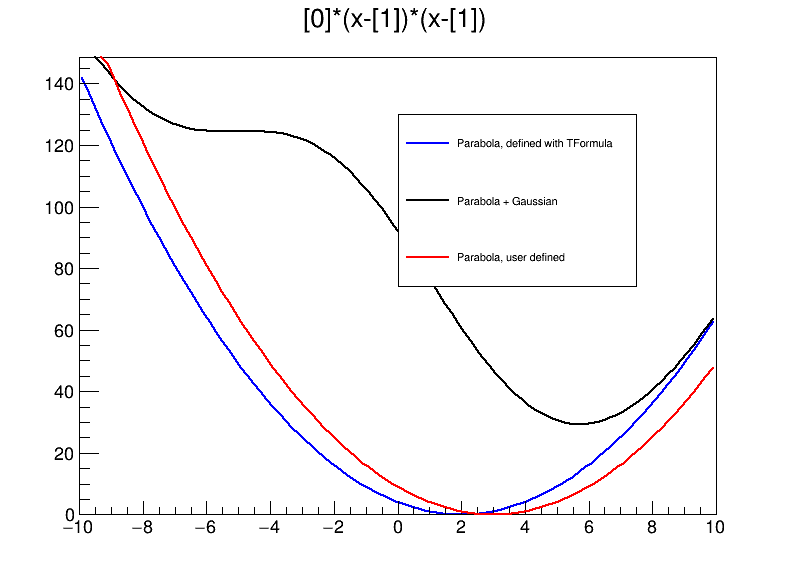

In [21]:
### create the legend object
leg = TLegend(0.5, 0.5, 0.8, 0.8) # the arguments are x1, y1, x2, y2 coordinates, given as fractions of the canvas size

### add the curves we drew above to the legend. Syntax is TLegend::AddEntry(drawn_object, title, plot_style)
leg.AddEntry(f1, "Parabola, defined with TFormula", "l") # "l" means "line", i.e. the line of f1 will be shown in the legend
leg.AddEntry(f2, "Parabola + Gaussian", "l")
leg.AddEntry(f3, "Parabola, user defined", "l")

## make legend prettier
# ...

## draw legend
leg.Draw()
canvas.Draw()



_______________________________________________________________
Make sure the font in the legend is not too small. This can be set with `leg.SetTextSize(x)` where `x` is fraction of canvas size. The legend border can be removed with `leg.SetLegendBorderSize(0)`. Change the code block above to make the legend prettier.
_______________________________________________________________

________________________________________________________________________________
### Answer the following questions. You will need to understand them to properly explain the fit procedure when writing the report. 
* In a histogram, if drawn with with some `e` option, data points will be displayed with an uncertainty. ROOT has automatically evaluated the uncertainty to... what?
* What determines the uncertainty on the fitted parameters? How can they be reduced?
* ROOT uses the weighted least squares ($\chi^2$) fit by default. When is this appropriate? What happens if we use the option `"L"`?
